In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print(gpu_devices)
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)


import matplotlib.pyplot as plt
import os
import re
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import datetime
np.random.seed(42)
tf.random.set_seed(42)

print("Tensorflow version " + tf.__version__)
print("tf.keras version " + tf.keras.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2060 SUPER, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
Tensorflow version 2.4.0
tf.keras version 2.4.0


In [3]:
IMG_PATH = "images"

In [4]:
result = [[y.split("/")[-2],os.path.join(y.split("/")[-2],y.split("/")[-1])] for x in os.walk(IMG_PATH) for y in glob(os.path.join(x[0], '*.jpg'))]

In [5]:
result[0]

['vacuole', 'vacuole/vacuole.205.jpg']

In [6]:
image_df = pd.DataFrame(result, columns = ['label', 'filename'])

In [7]:
image_df['label'].unique()

array(['vacuole', 'periphery', 'cytosol', 'mitochondrion',
       'endoplasmic_reticulum', 'golgi', 'nucleus', 'microtubules',
       'cytosol_and_nucleus'], dtype=object)

<AxesSubplot:>

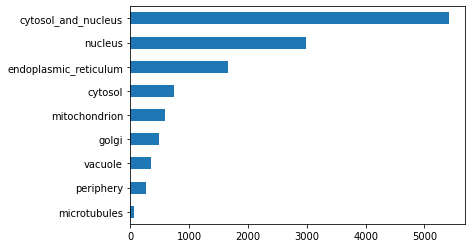

In [8]:
image_df['label'].value_counts().sort_values().plot(kind = 'barh')

In [9]:
image_df['label'].value_counts().sort_values()

microtubules               64
periphery                 263
vacuole                   347
golgi                     494
mitochondrion             591
cytosol                   743
endoplasmic_reticulum    1660
nucleus                  2984
cytosol_and_nucleus      5416
Name: label, dtype: int64

In [10]:
# split df into train and test
train_df, validation_df = train_test_split(image_df, test_size=0.05)
train_df, test_df = train_test_split(train_df, test_size=0.05)

In [11]:
train_df = train_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)
validation_df = validation_df.reset_index(drop = True)

In [12]:
train_df.head()

,label,filename
0,endoplasmic_reticulum,endoplasmic_reticulum/endoplasmic_reticulum.14...
1,endoplasmic_reticulum,endoplasmic_reticulum/endoplasmic_reticulum.15...
2,endoplasmic_reticulum,endoplasmic_reticulum/endoplasmic_reticulum.64...
3,nucleus,nucleus/nucleus.2285.jpg
4,cytosol_and_nucleus,cytosol_and_nucleus/cytosol_and_nucleus.3063.jpg


In [13]:
train_count_dict = dict(train_df['label'].value_counts())
train_count_dict

{'cytosol_and_nucleus': 4892,
 'nucleus': 2722,
 'endoplasmic_reticulum': 1491,
 'cytosol': 664,
 'mitochondrion': 528,
 'golgi': 436,
 'vacuole': 303,
 'periphery': 240,
 'microtubules': 60}

In [14]:
test_count_dict = dict(test_df['label'].value_counts())
test_count_dict

{'cytosol_and_nucleus': 266,
 'nucleus': 120,
 'endoplasmic_reticulum': 74,
 'cytosol': 46,
 'mitochondrion': 29,
 'golgi': 28,
 'vacuole': 21,
 'periphery': 11,
 'microtubules': 2}

In [15]:
validation_count_dict = dict(validation_df['label'].value_counts())
validation_count_dict

{'cytosol_and_nucleus': 258,
 'nucleus': 142,
 'endoplasmic_reticulum': 95,
 'mitochondrion': 34,
 'cytosol': 33,
 'golgi': 30,
 'vacuole': 23,
 'periphery': 12,
 'microtubules': 2}

In [15]:
upsampled_train_df = train_df.copy()
upsampled_train_df

,label,filename
0,endoplasmic_reticulum,endoplasmic_reticulum/endoplasmic_reticulum.14...
1,endoplasmic_reticulum,endoplasmic_reticulum/endoplasmic_reticulum.15...
2,endoplasmic_reticulum,endoplasmic_reticulum/endoplasmic_reticulum.64...
3,nucleus,nucleus/nucleus.2285.jpg
4,cytosol_and_nucleus,cytosol_and_nucleus/cytosol_and_nucleus.3063.jpg
...,...,...
11331,cytosol_and_nucleus,cytosol_and_nucleus/cytosol_and_nucleus.4066.jpg
11332,cytosol_and_nucleus,cytosol_and_nucleus/cytosol_and_nucleus.3730.jpg
11333,nucleus,nucleus/nucleus.670.jpg
11334,cytosol_and_nucleus,cytosol_and_nucleus/cytosol_and_nucleus.4173.jpg


In [16]:
for organelle in train_count_dict:
    if train_count_dict[organelle] < 500:
        upsampled_train_df = pd.concat([upsampled_train_df, resample(upsampled_train_df[upsampled_train_df['label'] == organelle], replace=True, n_samples=500 - train_count_dict[organelle], random_state = 42)])

In [17]:
upsampled_train_df['label'].value_counts()

cytosol_and_nucleus      4892
nucleus                  2722
endoplasmic_reticulum    1491
cytosol                   664
mitochondrion             528
microtubules              500
periphery                 500
golgi                     500
vacuole                   500
Name: label, dtype: int64

In [18]:
downsampled_train_df = pd.DataFrame(columns = ['label', 'filename'])

In [19]:
for organelle in train_count_dict:
    if train_count_dict[organelle] < 3000 and train_count_dict[organelle] >= 500:
        row_count = train_count_dict[organelle]
    elif train_count_dict[organelle] < 500:
        row_count = 500
    else:
        row_count = 3000
    downsampled_train_df = pd.concat([downsampled_train_df, resample(upsampled_train_df[upsampled_train_df['label'] == organelle], replace=False, n_samples=row_count, random_state = 42)])

In [20]:
downsampled_train_df['label'].value_counts()

cytosol_and_nucleus      3000
nucleus                  2722
endoplasmic_reticulum    1491
cytosol                   664
mitochondrion             528
microtubules              500
periphery                 500
golgi                     500
vacuole                   500
Name: label, dtype: int64

In [21]:
downsampled_train_df

,label,filename
328,cytosol_and_nucleus,cytosol_and_nucleus/cytosol_and_nucleus.3108.jpg
196,cytosol_and_nucleus,cytosol_and_nucleus/cytosol_and_nucleus.4315.jpg
6135,cytosol_and_nucleus,cytosol_and_nucleus/cytosol_and_nucleus.3512.jpg
10197,cytosol_and_nucleus,cytosol_and_nucleus/cytosol_and_nucleus.3596.jpg
5617,cytosol_and_nucleus,cytosol_and_nucleus/cytosol_and_nucleus.2951.jpg
...,...,...
9344,microtubules,microtubules/microtubules.6.jpg
830,microtubules,microtubules/microtubules.57.jpg
10574,microtubules,microtubules/microtubules.10.jpg
4403,microtubules,microtubules/microtubules.44.jpg


In [24]:
conv_base = tf.keras.applications.MobileNetV2(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(224,224,3)
)

pombEye_mobilenetv2 = tf.keras.models.Sequential()

pombEye_mobilenetv2.add(conv_base)

pombEye_mobilenetv2.add(tf.keras.layers.GlobalAveragePooling2D())
pombEye_mobilenetv2.add(tf.keras.layers.Dropout(0.2))
pombEye_mobilenetv2.add(tf.keras.layers.Dense(len(downsampled_train_df['label'].unique())))
pombEye_mobilenetv2.add(tf.keras.layers.Activation('softmax', dtype='float32', name='pombEye_prediction'))


In [25]:
for layer in conv_base.layers:
    print(layer.name)

input_1
Conv1_pad
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
bloc

In [26]:
pombEye_mobilenetv2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 11529     
_________________________________________________________________
pombEye_prediction (Activati (None, 9)                 0         
Total params: 2,269,513
Trainable params: 2,235,401
Non-trainable params: 34,112
_________________________________________________________________


In [27]:
conv_base.trainable = False

In [28]:
pombEye_mobilenetv2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 11529     
_________________________________________________________________
pombEye_prediction (Activati (None, 9)                 0         
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
vertical_flip = True,
rotation_range=360,
width_shift_range=0.3,
height_shift_range=0.3,
brightness_range=[0.8,1.2],
zoom_range=[0.8, 1.2],
fill_mode="constant",
cval=20.0)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

batchSize = 128

train_generator=train_datagen.flow_from_dataframe(
dataframe=downsampled_train_df,
directory="/data/Linux/pombEye/pombEye/images",
x_col="filename",
y_col='label',
batch_size=batchSize,
seed=42,
shuffle=True,
class_mode='categorical',
target_size=(224,224))

valid_generator=valid_datagen.flow_from_dataframe(
dataframe=validation_df,
directory="/data/Linux/pombEye/pombEye/images",
x_col="filename",
y_col='label',
batch_size=batchSize,
seed=42,
shuffle=True,
class_mode='categorical',
target_size=(224,224))

NameError: name 'downsampled_train_df' is not defined

In [30]:
pombEye_mobilenetv2.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
          loss = "categorical_crossentropy",
          metrics = ['accuracy']) 

In [31]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=3, verbose = 1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=7, restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint("pombEye_mobilenetv2.h5", monitor='val_loss', verbose=1, 
                                                save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [32]:
history = pombEye_mobilenetv2.fit(train_generator,steps_per_epoch = train_generator.n//train_generator.batch_size,
                              epochs= 30,callbacks=[checkpoint,reduce_lr, early_stopping_cb, tensorboard_cb],
                            validation_data = valid_generator,
                            validation_steps= valid_generator.n//valid_generator.batch_size,
                              shuffle=True)

Epoch 1/30
81/81 [==============================] - ETA: 0s - loss: 1.9623 - accuracy: 0.3425
Epoch 00001: val_loss improved from inf to 1.49823, saving model to pombEye_mobilenetv2.h5
81/81 [==============================] - 65s 799ms/step - loss: 1.9623 - accuracy: 0.3425 - val_loss: 1.4982 - val_accuracy: 0.5645 - lr: 1.0000e-04
Epoch 2/30
81/81 [==============================] - ETA: 0s - loss: 1.5205 - accuracy: 0.5036
Epoch 00002: val_loss improved from 1.49823 to 1.26653, saving model to pombEye_mobilenetv2.h5
81/81 [==============================] - 65s 802ms/step - loss: 1.5205 - accuracy: 0.5036 - val_loss: 1.2665 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 3/30
81/81 [==============================] - ETA: 0s - loss: 1.3367 - accuracy: 0.5628
Epoch 00003: val_loss improved from 1.26653 to 1.13462, saving model to pombEye_mobilenetv2.h5
81/81 [==============================] - 65s 797ms/step - loss: 1.3367 - accuracy: 0.5628 - val_loss: 1.1346 - val_accuracy: 0.6719 - lr: 1

In [33]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block_16_expand':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

pombEye_mobilenetv2.compile(optimizer= tf.keras.optimizers.RMSprop(lr=1e-5),
  loss = "categorical_crossentropy",
  metrics = ['accuracy']) 

pombEye_mobilenetv2.fit(train_generator,steps_per_epoch = train_generator.n//train_generator.batch_size,
                              epochs= 100 ,callbacks=[checkpoint,reduce_lr, early_stopping_cb, tensorboard_cb],
                            validation_data = valid_generator,
                            validation_steps= valid_generator.n//valid_generator.batch_size,
                              shuffle=True)

Epoch 1/100
81/81 [==============================] - ETA: 0s - loss: 0.9178 - accuracy: 0.6889
Epoch 00001: val_loss improved from 0.68241 to 0.67970, saving model to pombEye_mobilenetv2.h5
81/81 [==============================] - 64s 789ms/step - loss: 0.9178 - accuracy: 0.6889 - val_loss: 0.6797 - val_accuracy: 0.7695 - lr: 1.0000e-05
Epoch 2/100
81/81 [==============================] - ETA: 0s - loss: 0.7732 - accuracy: 0.7369
Epoch 00002: val_loss did not improve from 0.67970
81/81 [==============================] - 63s 779ms/step - loss: 0.7732 - accuracy: 0.7369 - val_loss: 0.6930 - val_accuracy: 0.7656 - lr: 1.0000e-05
Epoch 3/100
81/81 [==============================] - ETA: 0s - loss: 0.7349 - accuracy: 0.7470
Epoch 00003: val_loss did not improve from 0.67970
81/81 [==============================] - 63s 774ms/step - loss: 0.7349 - accuracy: 0.7470 - val_loss: 0.6971 - val_accuracy: 0.7656 - lr: 1.0000e-05
Epoch 4/100
81/81 [==============================] - ETA: 0s - loss: 0.

In [34]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block_15_expand':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

pombEye_mobilenetv2.compile(optimizer= tf.keras.optimizers.RMSprop(lr=1e-5),
  loss = "categorical_crossentropy",
  metrics = ['accuracy']) 

pombEye_mobilenetv2.fit(train_generator,steps_per_epoch = train_generator.n//train_generator.batch_size,
                              epochs= 100 ,callbacks=[checkpoint,reduce_lr, early_stopping_cb, tensorboard_cb],
                            validation_data = valid_generator,
                            validation_steps= valid_generator.n//valid_generator.batch_size,
                              shuffle=True)

Epoch 1/100
81/81 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.7604
Epoch 00001: val_loss did not improve from 0.59425
81/81 [==============================] - 92s 1s/step - loss: 0.6941 - accuracy: 0.7604 - val_loss: 0.6181 - val_accuracy: 0.8066 - lr: 1.0000e-05
Epoch 2/100
81/81 [==============================] - ETA: 0s - loss: 0.6421 - accuracy: 0.7785
Epoch 00002: val_loss did not improve from 0.59425
81/81 [==============================] - 97s 1s/step - loss: 0.6421 - accuracy: 0.7785 - val_loss: 0.6218 - val_accuracy: 0.8047 - lr: 1.0000e-05
Epoch 3/100
81/81 [==============================] - ETA: 0s - loss: 0.6181 - accuracy: 0.7832
Epoch 00003: val_loss did not improve from 0.59425
81/81 [==============================] - 75s 930ms/step - loss: 0.6181 - accuracy: 0.7832 - val_loss: 0.6178 - val_accuracy: 0.8027 - lr: 1.0000e-05
Epoch 4/100
81/81 [==============================] - ETA: 0s - loss: 0.5937 - accuracy: 0.7918
Epoch 00004: val_loss did 

In [35]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block_14_expand':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

pombEye_mobilenetv2.compile(optimizer= tf.keras.optimizers.RMSprop(lr=1e-6),
  loss = "categorical_crossentropy",
  metrics = ['accuracy']) 

pombEye_mobilenetv2.fit(train_generator,steps_per_epoch = train_generator.n//train_generator.batch_size,
                              epochs= 100 ,callbacks=[checkpoint,reduce_lr, early_stopping_cb, tensorboard_cb],
                            validation_data = valid_generator,
                            validation_steps= valid_generator.n//valid_generator.batch_size,
                              shuffle=True)

Epoch 1/100
81/81 [==============================] - ETA: 0s - loss: 0.5081 - accuracy: 0.8190
Epoch 00001: val_loss did not improve from 0.46900
81/81 [==============================] - 141s 2s/step - loss: 0.5081 - accuracy: 0.8190 - val_loss: 0.5050 - val_accuracy: 0.8379 - lr: 1.0000e-06
Epoch 2/100
81/81 [==============================] - ETA: 0s - loss: 0.5078 - accuracy: 0.8206
Epoch 00002: val_loss did not improve from 0.46900
81/81 [==============================] - 112s 1s/step - loss: 0.5078 - accuracy: 0.8206 - val_loss: 0.5078 - val_accuracy: 0.8340 - lr: 1.0000e-06
Epoch 3/100
81/81 [==============================] - ETA: 0s - loss: 0.4925 - accuracy: 0.8274
Epoch 00003: val_loss did not improve from 0.46900
81/81 [==============================] - 117s 1s/step - loss: 0.4925 - accuracy: 0.8274 - val_loss: 0.4908 - val_accuracy: 0.8418 - lr: 1.0000e-06
Epoch 4/100
81/81 [==============================] - ETA: 0s - loss: 0.4968 - accuracy: 0.8265
Epoch 00004: val_loss did 

# Test dataset

In [16]:
os.listdir()

['pombEye_v3_large.ipynb',
 'pombEye_mobilenetv3.h5',
 'pombEye_efficientnetB1.h5',
 'logs',
 'images',
 'pombEye_efficientnet.h5',
 'pombEye_xception.h5',
 'pombEye_v3.ipynb',
 'pombEye_mobilenetv2.h5',
 '.ipynb_checkpoints']

In [19]:
pombEye_mobilenetv2 = tf.keras.models.load_model('pombEye_mobilenetv2.h5')

In [23]:
from sklearn import metrics

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

test_generator=valid_datagen.flow_from_dataframe(
dataframe=test_df,
directory="images",
x_col="filename",
y_col='label',
batch_size=8,
seed=42,
shuffle=False,
class_mode='categorical',
target_size=(224,224))

test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = pombEye_mobilenetv2.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 

print(metrics.classification_report(true_classes, predicted_classes, target_names=class_labels))

Found 597 validated image filenames belonging to 9 classes.
                       precision    recall  f1-score   support

              cytosol       0.68      0.61      0.64        46
  cytosol_and_nucleus       0.91      0.89      0.90       266
endoplasmic_reticulum       0.93      0.77      0.84        74
                golgi       0.50      0.75      0.60        28
         microtubules       0.25      0.50      0.33         2
        mitochondrion       0.80      0.69      0.74        29
              nucleus       0.84      0.89      0.86       120
            periphery       0.55      1.00      0.71        11
              vacuole       0.82      0.67      0.74        21

             accuracy                           0.83       597
            macro avg       0.70      0.75      0.71       597
         weighted avg       0.84      0.83      0.83       597



In [24]:
metrics.confusion_matrix(true_classes, predicted_classes)

array([[ 28,  17,   0,   1,   0,   0,   0,   0,   0],
       [ 12, 236,   0,   2,   0,   0,  12,   3,   1],
       [  1,   2,  57,   4,   1,   0,   3,   5,   1],
       [  0,   0,   1,  21,   0,   2,   4,   0,   0],
       [  0,   0,   0,   0,   1,   0,   1,   0,   0],
       [  0,   1,   2,   3,   2,  20,   0,   0,   1],
       [  0,   3,   0,   7,   0,   2, 107,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,  11,   0],
       [  0,   0,   1,   4,   0,   1,   1,   0,  14]])

In [26]:
test_generator.class_indices.keys()

dict_keys(['cytosol', 'cytosol_and_nucleus', 'endoplasmic_reticulum', 'golgi', 'microtubules', 'mitochondrion', 'nucleus', 'periphery', 'vacuole'])